In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 
#프로그레스바가 나타나지 않습니다.


(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
)



Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-21 03:34:58.692467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-21 03:34:58.692575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [4]:
#노멀라이즈를 통해 로컬 옵티마의 깊이를 줄게여서  빨리빠져 나오게 함
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    image = (image / 255.0)
    return  image, label

In [5]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

2021-12-21 03:34:58.803912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 03:34:58.804096: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


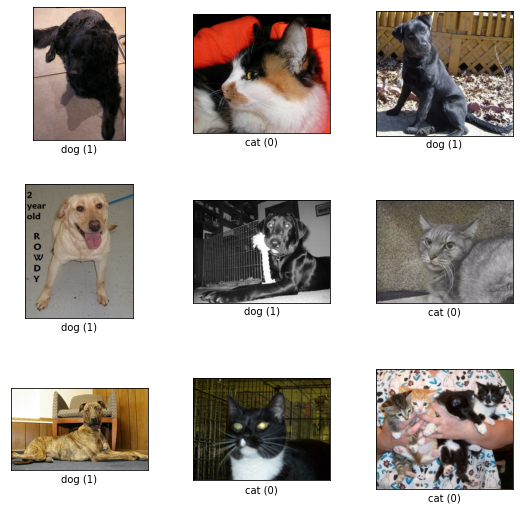

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

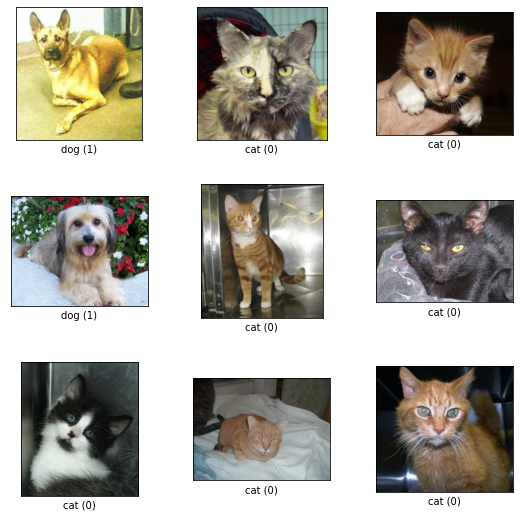

In [7]:
fig = tfds.show_examples(ds_test, ds_info)

(375, 500, 3)
0
(500, 345, 3)
1
(375, 500, 3)
1


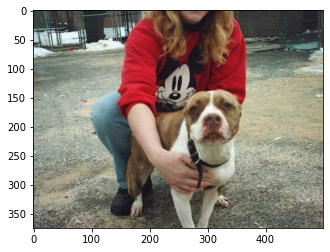

In [8]:
for data in ds_train.take(3):
    plt.imshow(data['image'])
    print(data['image'].shape)
    print(data['label'].numpy())

![resnet](https://d3s0tskafalll9.cloudfront.net/media/images/GC-1-P-table1.max-800x600.png)

In [9]:
#채널사이즈는 매개변수 입력하고 = 지정연산자로 넣는다. 블록반복수 지정.


# function for building resnet Block
# blocknum은 레이어의 이름
# input_layer 요약 출력을 위해서사용

def build_resnet34_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    _kernal_size = 3,
                    _fix = True,
                    _plane = False
                   ):
    # 입력 레이어
    x = input_layer
    shortcut_layer = input_layer

    is_First = True
    # CNN 레이어 커널 3by3
    # x = func()(x) 구조 레이어 변수에 계속 누적된다.
    
    for cnn_num in range(num_cnn):
        
        _stride = (1,1)
        if _fix:
            if not  is_First:
                _stride = (1,1)
            elif is_First:
                _stride = (2,2)

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            strides=_stride,

            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2}',
            use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(_kernal_size,_kernal_size),
            kernel_initializer='he_normal',
            strides=1,
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 2 + 1}',
            use_bias=False #배치노말에 이미 편향 들어감
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)



        if not _plane:
            if not  is_First:
                shortcut_layer = keras.layers.BatchNormalization(
                )(shortcut_layer)
                x = keras.layers.Add()([x,shortcut_layer])

        x = keras.layers.Activation('relu'
        )(x)

        shortcut_layer = x
        is_First = False


        
  

    # Max Pooling 레이어
    # 2by2 stri 2
    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2, 2),
    #     strides=2,
    #     name=f'block{block_num}_pooling'
    # )(x)
    #레이를를 반환
    return x

In [10]:
def build_resnet50_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                    _kernal_size = 3,
                    _fix = True,
                    _plane = False
                   ):
    # 입력 레이어
    x = input_layer
    shortcut_layer = input_layer

    is_First = True
    # CNN 레이어 커널 3by3
    # x = func()(x) 구조 레이어 변수에 계속 누적된다.
    
    for cnn_num in range(num_cnn):
        
        _stride = (1,1)
        if _fix:
            if not  is_First:
                _stride = (1,1)
            elif is_First:
                _stride = (2,2)

        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            strides=_stride,

            padding='same',
            name=f'block{block_num}_conv{cnn_num * 3}',
            use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)


        x = keras.layers.Conv2D(
        filters=channel,
        kernel_size=(3,3),
        kernel_initializer='he_normal',
        strides=_stride,

        padding='same',
        name=f'block{block_num}_conv{cnn_num * 3 +1}',
        use_bias=False #배치노말에 이미 편향 들
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)
        x = keras.layers.Activation('relu'
        )(x)
        
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            strides=1,
            padding='same',
            name=f'block{block_num}_conv{cnn_num * 3 + 2}',
            use_bias=False #배치노말에 이미 편향 들어감
        )(x)
        
        x = keras.layers.BatchNormalization(
        )(x)


        if not _plane:
            if not  is_First:
                shortcut_layer = keras.layers.BatchNormalization(
                )(shortcut_layer)
                x = keras.layers.Add()([x,shortcut_layer])

        x = keras.layers.Activation('relu'
        )(x)

        shortcut_layer = x
        is_First = False


        
  

    # Max Pooling 레이어
    # 2by2 stri 2
    # x = keras.layers.MaxPooling2D(
    #     pool_size=(2, 2),
    #     strides=2,
    #     name=f'block{block_num}_pooling'
    # )(x)
    #레이를를 반환
    return x

In [11]:
def build_resnet34_init(input_layer):

    x = input_layer
    x = keras.layers.Conv2D(
            filters=64,
            kernel_size=(7,7),
            kernel_initializer='he_normal',
            padding='same',
            name=f'block1_conv1',
            use_bias=False, #배치노말에 이미 편향 들
            strides=(2, 2)
        )(x)

    x = keras.layers.BatchNormalization(
    )(x)

    x = keras.layers.Activation('relu'
    )(x)
    #0 이하는 활성 안한다 = 필요없다!
    # 큰값은 더크게 나옴 큰특징을 원한다.

    #
    x = keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2),padding='same')(x)

    return x
    

In [12]:
def build_resnet34_finish(input_layer):
    x = input_layer

    x = keras.layers.AveragePooling2D(padding='same')(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(2, activation='softmax')(x)
    #x = keras.layers.Activation('softmax')(x)
    return x



In [13]:
#%debug (build_resnet34_block)

In [14]:

def build_resnet(input_shape=(224,224,3),is_50 = False, plane = False):

    resnet_input_layer = keras.layers.Input(input_shape)   # 입력 레이어 생성

    resnet_block_output = build_resnet34_init(resnet_input_layer) 

    if is_50:
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=2,_fix = False,_plane= plane)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=3,channel=128,num_cnn=4,_plane= plane)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=4,channel=256,num_cnn=6,_plane= plane)
        resnet_block_output = build_resnet50_block(resnet_block_output,block_num=5,channel=512,num_cnn=3,_plane= plane)
  
    else:
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=2,_fix = False,_plane= plane)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=3,channel=128,num_cnn=4,_plane= plane)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=4,channel=256,num_cnn=6,_plane= plane)
        resnet_block_output = build_resnet34_block(resnet_block_output,block_num=5,channel=512,num_cnn=3,_plane= plane)
    
    resnet_block_output = build_resnet34_finish(resnet_block_output)

    model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

    model.summary()
    return model

resnet34 = build_resnet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
resnet50 = build_resnet(is_50= True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 112, 112, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_45[0][0]     
____________________________________________________________________________________________

In [16]:
plane34 = build_resnet(is_50= True,plane= True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_106 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv0 (Conv2D)        (None, 56, 56, 64)        4096      
_________________________________________________________________
batch_normalization_107 (Bat (None, 56, 56, 64)        256 

In [17]:
plane50 = build_resnet(is_50= False,plane= True)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_155 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_131 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv0 (Conv2D)        (None, 56, 56, 64)        36864     
_________________________________________________________________
batch_normalization_156 (Bat (None, 56, 56, 64)        256 

In [18]:
BATCH_SIZE = 128
EPOCH = 5

resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True
)


ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)



/Users/woogyuchoi/miniforge3/envs/tf2/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [19]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [20]:
history_34 = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=2,
    use_multiprocessing=True,
)

Epoch 1/5


2021-12-21 03:35:02.560167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
2021-12-21 03:35:12.845634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 151 of 200
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2021-12-21 03:35:17.076464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9

145/145 - 134s - loss: 0.7500 - accuracy: 0.5639 - val_loss: 0.7144 - val_accuracy: 0.4938
Epoch 2/5


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

145/145 - 117s - loss: 0.7110 - accuracy: 0.5885 - val_loss: 0.7122 - val_accuracy: 0.5065
Epoch 3/5


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

145/145 - 113s - loss: 0.6758 - accuracy: 0.6138 - val_loss: 0.6961 - val_accuracy: 0.5944
Epoch 4/5


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

145/145 - 115s - loss: 0.6537 - accuracy: 0.6316 - val_loss: 0.7462 - val_accuracy: 0.5987
Epoch 5/5


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 

145/145 - 115s - loss: 0.6368 - accuracy: 0.6479 - val_loss: 0.7293 - val_accuracy: 0.6146


In [21]:
history_50 = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


2021-12-21 03:44:59.434919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
2021-12-21 03:45:09.828056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 166 of 200
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2021-12-21 03:45:11.891879: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


  2/145 [..............................] - ETA: 3:05 - loss: 0.8923 - accuracy: 0.5156 

  4/145 [..............................] - ETA: 1:54 - loss: 0.9649 - accuracy: 0.5078

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 23/145 [===>..........................] - ETA: 1:09 - loss: 0.9296 - accuracy: 0.5163

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 75/145 [==============>...............] - ETA: 38s - loss: 0.8901 - accuracy: 0.5261

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/145 [==============>...............] - ETA: 37s - loss: 0.8883 - accuracy: 0.5264

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 36s - loss: 0.8892 - accuracy: 0.5259

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/145 [=================>............] - ETA: 33s - loss: 0.8846 - accuracy: 0.5261

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 31s - loss: 0.8814 - accuracy: 0.5277

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


140/145 [===========================>..] - ETA: 2s - loss: 0.8702 - accuracy: 0.5291

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.5292

2021-12-21 03:46:39.753271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG dat

145/145 [==============================] - 122s 688ms/step - loss: 0.8683 - accuracy: 0.5292 - val_loss: 0.6925 - val_accuracy: 0.5032
Epoch 2/5
  3/145 [..............................] - ETA: 1:08 - loss: 0.7962 - accuracy: 0.5417

  5/145 [>.............................] - ETA: 1:12 - loss: 0.8208 - accuracy: 0.5250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 24/145 [===>..........................] - ETA: 1:03 - loss: 0.8213 - accuracy: 0.5355

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/145 [==============>...............] - ETA: 38s - loss: 0.8106 - accuracy: 0.5431

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 37s - loss: 0.8108 - accuracy: 0.5433

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/145 [===============>..............] - ETA: 34s - loss: 0.8089 - accuracy: 0.5426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 30s - loss: 0.8081 - accuracy: 0.5421

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 30s - loss: 0.8071 - accuracy: 0.5420

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 2s - loss: 0.8006 - accuracy: 0.5429

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.8003 - accuracy: 0.5425

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:48:31.274033: I tensorflow/core/kernel

145/145 [==============================] - 103s 701ms/step - loss: 0.8003 - accuracy: 0.5425 - val_loss: 0.7026 - val_accuracy: 0.4991
Epoch 3/5
  4/145 [..............................] - ETA: 1:15 - loss: 0.7493 - accuracy: 0.5664

  7/145 [>.............................] - ETA: 1:13 - loss: 0.7673 - accuracy: 0.5536

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 25/145 [====>.........................] - ETA: 1:02 - loss: 0.7796 - accuracy: 0.5359

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/145 [==============>...............] - ETA: 36s - loss: 0.7811 - accuracy: 0.5375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 33s - loss: 0.7783 - accuracy: 0.5396

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/145 [===============>..............] - ETA: 33s - loss: 0.7781 - accuracy: 0.5394

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 29s - loss: 0.7772 - accuracy: 0.5413

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 28s - loss: 0.7769 - accuracy: 0.5422

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


142/145 [============================>.] - ETA: 1s - loss: 0.7763 - accuracy: 0.5419

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7765 - accuracy: 0.5420

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:50:09.479095: I tensorflow/core/kernel

145/145 [==============================] - 99s 674ms/step - loss: 0.7765 - accuracy: 0.5420 - val_loss: 0.7116 - val_accuracy: 0.5382
Epoch 4/5
  5/145 [>.............................] - ETA: 1:14 - loss: 0.7578 - accuracy: 0.5297

  7/145 [>.............................] - ETA: 1:10 - loss: 0.7621 - accuracy: 0.5424

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 26/145 [====>.........................] - ETA: 1:01 - loss: 0.7661 - accuracy: 0.5337

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 34s - loss: 0.7649 - accuracy: 0.5414

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 33s - loss: 0.7661 - accuracy: 0.5423

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/145 [================>.............] - ETA: 31s - loss: 0.7636 - accuracy: 0.5443

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 28s - loss: 0.7633 - accuracy: 0.5436

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/145 [==================>...........] - ETA: 27s - loss: 0.7638 - accuracy: 0.5438

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


143/145 [============================>.] - ETA: 1s - loss: 0.7567 - accuracy: 0.5508

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7571 - accuracy: 0.5505

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:51:48.309525: I tensorflow/core/kernel

145/145 [==============================] - 99s 672ms/step - loss: 0.7571 - accuracy: 0.5505 - val_loss: 0.7423 - val_accuracy: 0.5449
Epoch 5/5
  6/145 [>.............................] - ETA: 1:11 - loss: 0.7617 - accuracy: 0.5221

  8/145 [>.............................] - ETA: 1:10 - loss: 0.7601 - accuracy: 0.5410

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 27/145 [====>.........................] - ETA: 1:01 - loss: 0.7591 - accuracy: 0.5379

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 39s - loss: 0.7705 - accuracy: 0.5451

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/145 [===============>..............] - ETA: 37s - loss: 0.7698 - accuracy: 0.5452

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/145 [================>.............] - ETA: 34s - loss: 0.7701 - accuracy: 0.5440

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 31s - loss: 0.7676 - accuracy: 0.5456

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/145 [==================>...........] - ETA: 29s - loss: 0.7681 - accuracy: 0.5455

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


144/145 [============================>.] - ETA: 0s - loss: 0.7601 - accuracy: 0.5462

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7602 - accuracy: 0.5463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:53:31.669534: I tensorflow/core/kernel

145/145 [==============================] - 102s 695ms/step - loss: 0.7602 - accuracy: 0.5463 - val_loss: 0.7489 - val_accuracy: 0.5293


In [22]:
plane34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p34 = plane34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/5


2021-12-21 03:53:43.397826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
2021-12-21 03:53:53.778726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 167 of 200
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2021-12-21 03:53:55.754109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


  1/145 [..............................] - ETA: 52:15 - loss: 0.7544 - accuracy: 0.5000

  4/145 [..............................] - ETA: 2:54 - loss: 0.8119 - accuracy: 0.4961

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 23/145 [===>..........................] - ETA: 1:33 - loss: 0.7804 - accuracy: 0.5202

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 75/145 [==============>...............] - ETA: 39s - loss: 0.7715 - accuracy: 0.5126

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 77/145 [==============>...............] - ETA: 38s - loss: 0.7699 - accuracy: 0.5128

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 36s - loss: 0.7712 - accuracy: 0.5126

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/145 [=================>............] - ETA: 32s - loss: 0.7728 - accuracy: 0.5109

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 30s - loss: 0.7725 - accuracy: 0.5107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


140/145 [===========================>..] - ETA: 2s - loss: 0.7657 - accuracy: 0.5138

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.5137

2021-12-21 03:55:18.676747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG dat

145/145 [==============================] - 117s 660ms/step - loss: 0.7647 - accuracy: 0.5137 - val_loss: 0.7078 - val_accuracy: 0.4861
Epoch 2/5
  3/145 [..............................] - ETA: 1:08 - loss: 0.7319 - accuracy: 0.5703

  5/145 [>.............................] - ETA: 1:05 - loss: 0.7241 - accuracy: 0.5484

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 24/145 [===>..........................] - ETA: 1:11 - loss: 0.7449 - accuracy: 0.5180

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 75/145 [==============>...............] - ETA: 35s - loss: 0.7422 - accuracy: 0.5141

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/145 [===============>..............] - ETA: 32s - loss: 0.7415 - accuracy: 0.5125

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/145 [===============>..............] - ETA: 31s - loss: 0.7413 - accuracy: 0.5129

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/145 [=================>............] - ETA: 28s - loss: 0.7417 - accuracy: 0.5124

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 27s - loss: 0.7428 - accuracy: 0.5120

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


141/145 [============================>.] - ETA: 1s - loss: 0.7385 - accuracy: 0.5142

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7387 - accuracy: 0.5140

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:57:01.132776: I tensorflow/core/kernel

145/145 [==============================] - 92s 630ms/step - loss: 0.7387 - accuracy: 0.5140 - val_loss: 0.7053 - val_accuracy: 0.5013
Epoch 3/5
  4/145 [..............................] - ETA: 1:02 - loss: 0.7271 - accuracy: 0.5254

  6/145 [>.............................] - ETA: 1:03 - loss: 0.7299 - accuracy: 0.5091

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 25/145 [====>.........................] - ETA: 55s - loss: 0.7263 - accuracy: 0.5169

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/145 [==============>...............] - ETA: 32s - loss: 0.7266 - accuracy: 0.5164

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 79/145 [===============>..............] - ETA: 31s - loss: 0.7265 - accuracy: 0.5165

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/145 [================>.............] - ETA: 29s - loss: 0.7255 - accuracy: 0.5176

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 25s - loss: 0.7249 - accuracy: 0.5176

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 25s - loss: 0.7255 - accuracy: 0.5173

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


142/145 [============================>.] - ETA: 1s - loss: 0.7220 - accuracy: 0.5217

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.5216

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 03:58:30.470877: I tensorflow/core/kernel

145/145 [==============================] - 89s 607ms/step - loss: 0.7224 - accuracy: 0.5216 - val_loss: 0.7574 - val_accuracy: 0.5142
Epoch 4/5
  5/145 [>.............................] - ETA: 1:09 - loss: 0.7042 - accuracy: 0.5531

  8/145 [>.............................] - ETA: 1:06 - loss: 0.7160 - accuracy: 0.5264

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 26/145 [====>.........................] - ETA: 56s - loss: 0.7225 - accuracy: 0.5219

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 77/145 [==============>...............] - ETA: 34s - loss: 0.7236 - accuracy: 0.5139

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/145 [===============>..............] - ETA: 32s - loss: 0.7246 - accuracy: 0.5126

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 84/145 [================>.............] - ETA: 30s - loss: 0.7238 - accuracy: 0.5141

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 27s - loss: 0.7236 - accuracy: 0.5135

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/145 [==================>...........] - ETA: 26s - loss: 0.7235 - accuracy: 0.5133

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


143/145 [============================>.] - ETA: 1s - loss: 0.7255 - accuracy: 0.5128

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.5130

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marke

145/145 [==============================] - 94s 641ms/step - loss: 0.7253 - accuracy: 0.5130 - val_loss: 0.9247 - val_accuracy: 0.5040
Epoch 5/5
  6/145 [>.............................] - ETA: 1:01 - loss: 0.7279 - accuracy: 0.5182

  8/145 [>.............................] - ETA: 1:01 - loss: 0.7296 - accuracy: 0.5127

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 27/145 [====>.........................] - ETA: 54s - loss: 0.7209 - accuracy: 0.5200

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 79/145 [===============>..............] - ETA: 31s - loss: 0.7205 - accuracy: 0.5170

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 82/145 [===============>..............] - ETA: 30s - loss: 0.7199 - accuracy: 0.5170

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/145 [================>.............] - ETA: 28s - loss: 0.7198 - accuracy: 0.5175

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 92/145 [==================>...........] - ETA: 25s - loss: 0.7200 - accuracy: 0.5161

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/145 [==================>...........] - ETA: 24s - loss: 0.7198 - accuracy: 0.5159

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


144/145 [============================>.] - ETA: 0s - loss: 0.7187 - accuracy: 0.5153

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.5156

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 04:01:38.081721: I tensorflow/core/kernel

145/145 [==============================] - 93s 638ms/step - loss: 0.7186 - accuracy: 0.5156 - val_loss: 0.7651 - val_accuracy: 0.5090


In [23]:
plane50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p50 = plane50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/5


2021-12-21 04:01:48.886016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
2021-12-21 04:01:59.164979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 171 of 200
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2021-12-21 04:02:00.945710: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


  2/145 [..............................] - ETA: 1:46 - loss: 0.7424 - accuracy: 0.5273 

  5/145 [>.............................] - ETA: 1:25 - loss: 0.7583 - accuracy: 0.5094

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 23/145 [===>..........................] - ETA: 1:12 - loss: 0.7280 - accuracy: 0.5248

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 74/145 [==============>...............] - ETA: 42s - loss: 0.7293 - accuracy: 0.5306

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 40s - loss: 0.7296 - accuracy: 0.5294

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 39s - loss: 0.7291 - accuracy: 0.5300

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 87/145 [=================>............] - ETA: 35s - loss: 0.7301 - accuracy: 0.5290

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 33s - loss: 0.7290 - accuracy: 0.5304

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


140/145 [===========================>..] - ETA: 3s - loss: 0.7241 - accuracy: 0.5338

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.5344

2021-12-21 04:03:36.778270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG dat

145/145 [==============================] - 129s 748ms/step - loss: 0.7237 - accuracy: 0.5344 - val_loss: 0.7566 - val_accuracy: 0.4881
Epoch 2/5
  3/145 [..............................] - ETA: 1:28 - loss: 0.7218 - accuracy: 0.5417

  5/145 [>.............................] - ETA: 1:22 - loss: 0.7367 - accuracy: 0.5312

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 24/145 [===>..........................] - ETA: 1:25 - loss: 0.7213 - accuracy: 0.5458

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/145 [==============>...............] - ETA: 44s - loss: 0.7150 - accuracy: 0.5491

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 43s - loss: 0.7145 - accuracy: 0.5488

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 81/145 [===============>..............] - ETA: 41s - loss: 0.7138 - accuracy: 0.5496

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 88/145 [=================>............] - ETA: 36s - loss: 0.7140 - accuracy: 0.5467

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 35s - loss: 0.7133 - accuracy: 0.5480

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


140/145 [===========================>..] - ETA: 3s - loss: 0.7137 - accuracy: 0.5469

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.5463

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 04:05:40.046426: I tensorflow/core/kernel

145/145 [==============================] - 114s 781ms/step - loss: 0.7148 - accuracy: 0.5463 - val_loss: 0.7461 - val_accuracy: 0.4907
Epoch 3/5
  4/145 [..............................] - ETA: 1:25 - loss: 0.6937 - accuracy: 0.5898

  6/145 [>.............................] - ETA: 1:23 - loss: 0.6894 - accuracy: 0.5794

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 25/145 [====>.........................] - ETA: 1:13 - loss: 0.7018 - accuracy: 0.5553

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 76/145 [==============>...............] - ETA: 42s - loss: 0.7072 - accuracy: 0.5534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 80/145 [===============>..............] - ETA: 39s - loss: 0.7064 - accuracy: 0.5555

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 82/145 [===============>..............] - ETA: 38s - loss: 0.7065 - accuracy: 0.5562

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 89/145 [=================>............] - ETA: 34s - loss: 0.7084 - accuracy: 0.5536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 33s - loss: 0.7086 - accuracy: 0.5530

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


142/145 [============================>.] - ETA: 1s - loss: 0.7093 - accuracy: 0.5511

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.5503

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marke

145/145 [==============================] - 111s 761ms/step - loss: 0.7093 - accuracy: 0.5503 - val_loss: 0.7132 - val_accuracy: 0.5376
Epoch 4/5
  4/145 [..............................] - ETA: 1:28 - loss: 0.6880 - accuracy: 0.5566

  8/145 [>.............................] - ETA: 1:28 - loss: 0.7054 - accuracy: 0.5469

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 26/145 [====>.........................] - ETA: 1:12 - loss: 0.7039 - accuracy: 0.5433

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 78/145 [===============>..............] - ETA: 40s - loss: 0.7051 - accuracy: 0.5557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/145 [===============>..............] - ETA: 40s - loss: 0.7047 - accuracy: 0.5570

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 83/145 [================>.............] - ETA: 39s - loss: 0.7040 - accuracy: 0.5575

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 90/145 [=================>............] - ETA: 35s - loss: 0.7029 - accuracy: 0.5598

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 92/145 [==================>...........] - ETA: 33s - loss: 0.7021 - accuracy: 0.5604

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


143/145 [============================>.] - ETA: 1s - loss: 0.7044 - accuracy: 0.5593

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.5598

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 04:09:24.994916: I tensorflow/core/kernel

145/145 [==============================] - 114s 785ms/step - loss: 0.7042 - accuracy: 0.5598 - val_loss: 0.7669 - val_accuracy: 0.5548
Epoch 5/5
  6/145 [>.............................] - ETA: 1:29 - loss: 0.6910 - accuracy: 0.5729

  8/145 [>.............................] - ETA: 1:27 - loss: 0.6882 - accuracy: 0.5752

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 27/145 [====>.........................] - ETA: 1:14 - loss: 0.7012 - accuracy: 0.5642

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


 79/145 [===============>..............] - ETA: 41s - loss: 0.7067 - accuracy: 0.5557

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 81/145 [===============>..............] - ETA: 40s - loss: 0.7061 - accuracy: 0.5553

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 85/145 [================>.............] - ETA: 37s - loss: 0.7067 - accuracy: 0.5540

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


 91/145 [=================>............] - ETA: 33s - loss: 0.7062 - accuracy: 0.5551

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 93/145 [==================>...........] - ETA: 32s - loss: 0.7064 - accuracy: 0.5551

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


144/145 [============================>.] - ETA: 0s - loss: 0.7055 - accuracy: 0.5573

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


145/145 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.5575

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
2021-12-21 04:11:18.998682: I tensorflow/core/kernel

145/145 [==============================] - 113s 771ms/step - loss: 0.7052 - accuracy: 0.5575 - val_loss: 0.6911 - val_accuracy: 0.5751


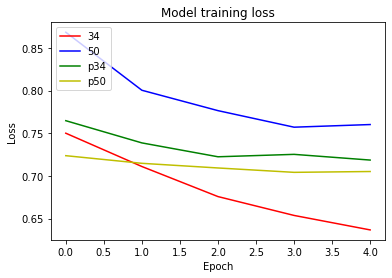

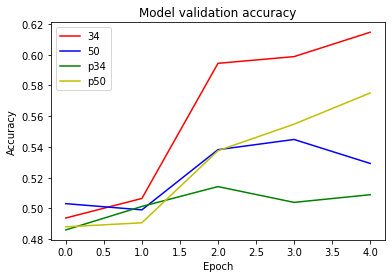

In [25]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.plot(history_p34.history['loss'], 'g')
plt.plot(history_p50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['34', '50','p34','p50'], loc='upper left')
plt.show()

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.plot(history_p34.history['val_accuracy'], 'g')
plt.plot(history_p50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['34', '50','p34','p50'], loc='upper left')
plt.show()
